In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter


In [26]:
def load_first_sheet(file_path="Student_Satisfaction_Survey_cleaned.xlsx"):
    x = pd.ExcelFile(file_path)
    sheet = x.sheet_names[0]
    df = pd.read_excel("Student_Satisfaction_Survey_cleaned.xlsx", sheet_name="Student_Satisfaction_Survey_cle")
    return df, sheet

In [27]:
df

,SN,Total Feedback Given,Total Configured,Questions,Weightage 1,Weightage 2,Weightage 3,Weightage 4,Weightage 5,Average,Percentage,Course Name,Basic Course
0,1,1,12,How much of the syllabus was covered in the cl...,0,0,1,0,0,3.00,60.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
1,2,1,12,How well did the teachers prepare for the clas...,0,0,0,0,1,5.00,100.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
2,3,1,12,How well were the teachers able to communicate?,0,0,0,0,1,5.00,100.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
3,4,1,12,The teacher’s approach to teaching can best be...,0,0,1,0,0,3.00,60.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
4,5,1,12,Fairness of the internal evaluation process by...,0,0,0,1,0,4.00,80.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,16,9,170,The institute/ teachers use student-centric me...,1,0,0,2,6,4.33,86.67,TYBSC,BACHELOR OF SCIENCE
576,17,9,170,Teachers encourage you to participate in extra...,0,0,0,3,6,4.67,93.33,TYBSC,BACHELOR OF SCIENCE
577,18,9,170,Efforts are made by the institute/ teachers to...,0,0,1,2,6,4.56,91.11,TYBSC,BACHELOR OF SCIENCE
578,19,9,170,What percentage of teachers use ICT tools such...,0,0,1,3,5,4.44,88.89,TYBSC,BACHELOR OF SCIENCE


In [14]:
df_raw, sheet_name = load_first_sheet()
print(f"Loaded sheet: Student_Satisfaction_Survey_cle  (shape: {df_raw.shape})")


df = df_raw.copy()
df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]

# Detect rating columns (Weightage 1..5 or similar)
rating_cols = [c for c in df.columns if re.search(r'weightage\s*1|weightage\s*2|weightage\s*3|weightage\s*4|weightage\s*5', str(c), flags=re.I)]
if not rating_cols:
    for i in range(1,6):
        for c in df.columns:
            if str(c).strip() == str(i) or re.search(rf'\b{i}\b', str(c)):
                rating_cols.append(c)
rating_cols = list(dict.fromkeys(rating_cols))[:5]

# Identify question, average and comment columns
question_col = None
for c in df.columns:
    if 'question' in str(c).lower() or 'questions' in str(c).lower():
        question_col = c
        break
if question_col is None:
    possible = [c for c in df.columns if df[c].dtype == object and df[c].nunique() < 200]
    if possible:
        question_col = max(possible, key=lambda cc: df[cc].nunique())

avg_col = None
for c in df.columns:
    if 'average' in str(c).lower() or str(c).lower() == 'avg':
        avg_col = c
        break

comment_col = None
for c in df.columns:
    if any(k in str(c).lower() for k in ['comment', 'feedback', 'remark', 'suggestion', 'response']):
        comment_col = c
        break

# If we have weightage columns, compute average if Average column not present
if rating_cols and not avg_col:
    weights = {rating_cols[i]: i+1 for i in range(len(rating_cols))}
    def compute_avg(row):
        num = 0
        den = 0
        for col, r in weights.items():
            val = row.get(col, 0)
            try:
                val = float(val) if not (pd.isna(val) or val=='') else 0.0
            except:
                val = 0.0
            num += r * val
            den += val
        return num/den if den>0 else np.nan
    df['computed_average'] = df.apply(compute_avg, axis=1)
    avg_col = 'computed_average'

print("Detected columns:")
print("  question_col:", question_col)
print("  rating_cols:", rating_cols)
print("  average_col:", avg_col)
print("  comment_col:", comment_col)

Loaded sheet: Student_Satisfaction_Survey_cle  (shape: (580, 13))
Detected columns:
  question_col: Questions
  rating_cols: ['Weightage 1', 'Weightage 2', 'Weightage 3', 'Weightage 4', 'Weightage 5']
  average_col: Average
  comment_col: Total Feedback Given


In [16]:
# 2. Analyze ratings (1-5) to find patterns
# -----------------------------
def melt_ratings(df, question_col, rating_cols):
    if not question_col or not rating_cols:
        return pd.DataFrame()
    df_r = df[[question_col] + rating_cols].copy()
    df_r = df_r.rename(columns={rating_cols[i]: f"rating_{i+1}" for i in range(len(rating_cols))})
    melted = df_r.melt(id_vars=[question_col], value_vars=[f"rating_{i+1}" for i in range(len(rating_cols))],
                       var_name="rating_label", value_name="count")
    melted['rating'] = melted['rating_label'].str.extract(r'(\d+)').astype(int)
    melted['count'] = pd.to_numeric(melted['count'], errors='coerce').fillna(0)
    grouped = melted.groupby([question_col, 'rating'], as_index=False)['count'].sum()
    return grouped

In [ ]:
ratings_long = melt_ratings(df, question_col, rating_cols)

In [17]:
# Average table (prefer avg_col if present)
if avg_col and avg_col in df.columns:
    avg_table = df[[question_col, avg_col]].copy().dropna(subset=[question_col]).drop_duplicates()
    avg_table = avg_table.groupby(question_col)[avg_col].mean().reset_index().rename(columns={avg_col:'average_rating'})
else:
    avg_table = ratings_long.copy()
    avg_table['weighted'] = avg_table['rating'] * avg_table['count']
    avg_table = avg_table.groupby(question_col).apply(lambda g: g['weighted'].sum()/g['count'].sum() if g['count'].sum()>0 else np.nan).reset_index()
    avg_table.columns = [question_col, 'average_rating']

avg_table = avg_table.sort_values('average_rating', ascending=False).reset_index(drop=True)

overall_avg = avg_table['average_rating'].mean()
print(f"Overall mean of question averages: {overall_avg:.3f}")

Overall mean of question averages: 3.822


In [29]:
# 3. Sentiment analysis (fallback lexicon, VADER if available)
# -----------------------------
def simple_lexicon_sentiment(text, pos_words=None, neg_words=None):
    if not isinstance(text, str) or text.strip()=='' or pd.isna(text):
        return {'score': 0.0, 'label':'neutral'}
    text_clean = re.sub(r'[^A-Za-z0-9\s]', ' ', text.lower())
    tokens = text_clean.split()
    pos_count = sum(1 for t in tokens if t in pos_words)
    neg_count = sum(1 for t in tokens if t in neg_words)
    score = (pos_count - neg_count) / max(1, (pos_count + neg_count))
    if pos_count+neg_count==0:
        label = 'neutral'
    elif score > 0.1:
        label = 'positive'
    elif score < -0.1:
        label = 'negative'
    else:
        label = 'neutral'
    return {'score': score, 'label': label, 'pos_count':pos_count, 'neg_count':neg_count}

POS_WORDS = set("""good great excellent nice helpful fantastic informative engaging useful clear loved amazing well organized organized supportive punctual""".split())
NEG_WORDS = set("""bad poor terrible boring unclear unhelpful awful slow confusing long late difficult irrelevant noisy rushed expensive unsatisfied dissatisfied""".split())


In [30]:
# Attempt to use VADER if nltk is installed and resources are present
try:
    from nltk.sentiment import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()
    def vader_sentiment(text):
        if not isinstance(text, str) or text.strip()=='' or pd.isna(text):
            return {'score': 0.0, 'label':'neutral'}
        vs = sia.polarity_scores(text)
        compound = vs['compound']
        if compound >= 0.05:
            label = 'positive'
        elif compound <= -0.05:
            label = 'negative'
        else:
            label = 'neutral'
        return {'score': compound, 'label': label}
    sentiment_fn = vader_sentiment
    print("Using NLTK VADER for sentiment scoring.")
except Exception:
    sentiment_fn = lambda t: simple_lexicon_sentiment(t, POS_WORDS, NEG_WORDS)
    print("VADER not available; using simple lexicon fallback for sentiment.")

sentiment_results = None
if comment_col and comment_col in df.columns:
    comments = df[[question_col, comment_col]].copy().dropna(subset=[comment_col])
    comments['comment_text'] = comments[comment_col].astype(str).str.strip()
    sentiments = comments['comment_text'].apply(sentiment_fn).apply(pd.Series)
    comments = pd.concat([comments.reset_index(drop=True), sentiments.reset_index(drop=True)], axis=1)
    sentiment_results = comments
else:
    print("No comment column detected — skipping sentiment analysis.")

VADER not available; using simple lexicon fallback for sentiment.


C:\Users\Admin\AppData\Local\Temp\ipykernel_16464\187058165.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


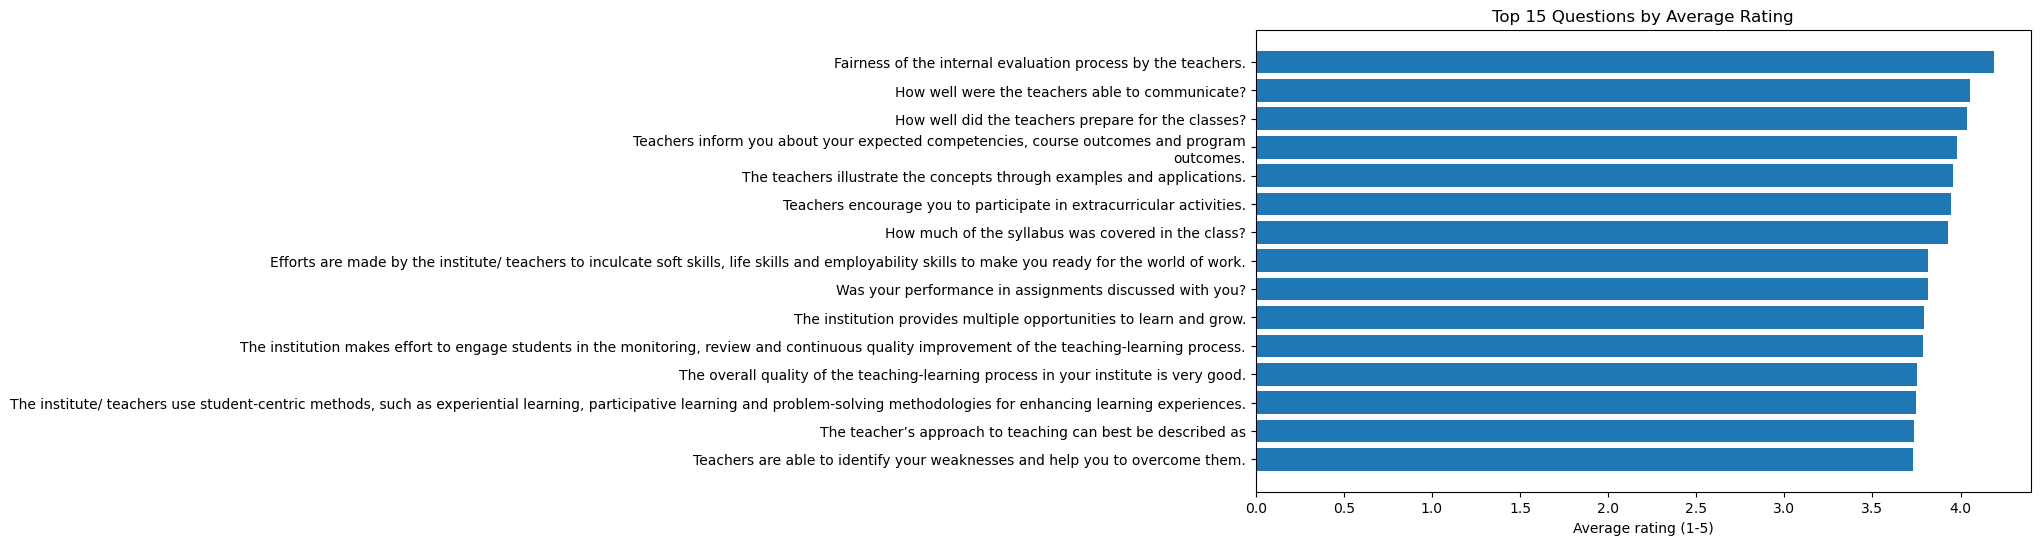

In [21]:
# 4. Visualizations (matplotlib)
# -----------------------------
# A: Bar chart of average rating per question (top 15)
plt.figure(figsize=(10,6))
topN = 15
plot_df = avg_table.head(topN).sort_values('average_rating', ascending=True)
plt.barh(plot_df[question_col].astype(str), plot_df['average_rating'])
plt.xlabel('Average rating (1-5)')
plt.title(f'Top {topN} Questions by Average Rating')
plt.tight_layout()
plt.show()


In [33]:
 #  B: Stacked bar for rating distribution for sample questions
sample_qs = list(avg_table.head(3)[question_col]) + list(avg_table.tail(3)[question_col])
sample_qs = [q for q in sample_qs if pd.notna(q)]
dist_df = ratings_long[ratings_long[question_col].isin(sample_qs)].pivot_table(index=question_col, columns='rating', values='count', aggfunc='sum', fill_value=0)
if not dist_df.empty:
    dist_df.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title('Rating distribution for sample best/worst questions')
    plt.xlabel('Question')
    plt.ylabel('Count of ratings')
    plt.legend(title='Rating')
    plt.tight_layout()
    plt.show()


NameError: name 'ratings_long' is not defined

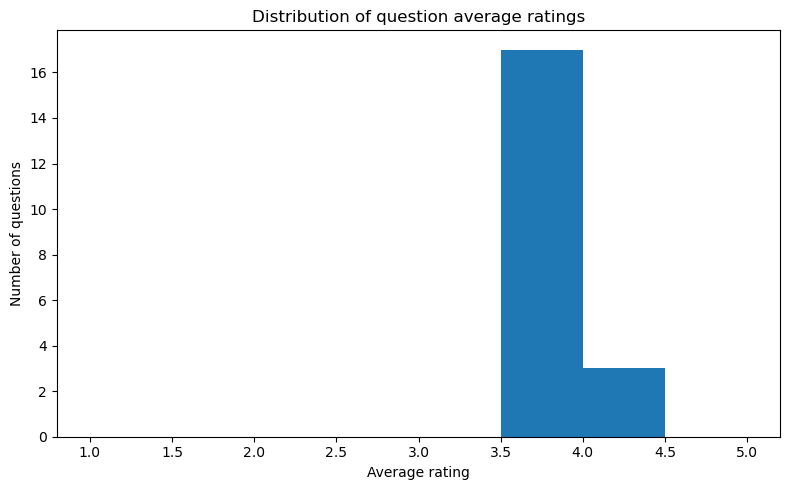

In [32]:
# C: Histogram of average ratings across questions
plt.figure(figsize=(8,5))
plt.hist(avg_table['average_rating'].dropna(), bins=[1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.xlabel('Average rating')
plt.ylabel('Number of questions')
plt.title('Distribution of question average ratings')
plt.tight_layout()
plt.show()

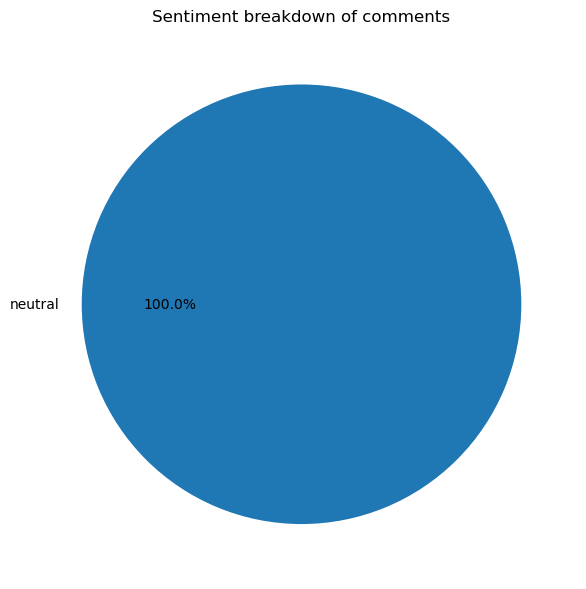

In [24]:
# D: Pie chart of sentiment labels (if comments present)
if sentiment_results is not None:
    plt.figure(figsize=(6,6))
    sentiment_counts = sentiment_results['label'].value_counts()
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
    plt.title('Sentiment breakdown of comments')
    plt.tight_layout()
    plt.show()

In [25]:
# 5. Suggest improvements for future events
# -----------------------------
def top_tokens_from_comments(comments_series, top_n=20, negative_only=False):
    cnt = Counter()
    for c in comments_series.dropna().astype(str):
        toks = re.findall(r"\b[a-zA-Z]{3,}\b", c.lower())
        if negative_only:
            toks = [t for t in toks if t in NEG_WORDS]
        cnt.update(toks)
    return cnt.most_common(top_n)

top_negative_tokens = []
if sentiment_results is not None:
    top_negative_tokens = top_tokens_from_comments(sentiment_results[sentiment_results['label']=='negative']['comment_text'], top_n=25, negative_only=False)

def suggest_improvements(avg_table, ratings_long, sentiment_results, top_negative_tokens, question_col=question_col):
    suggestions = []
    low = avg_table.sort_values('average_rating').head(5)
    if not low.empty:
        suggestions.append("Questions with lowest satisfaction (prioritize):")
        for _, row in low.iterrows():
            q = row[question_col]
            suggestions.append(f"- \"{q}\" — average rating {row['average_rating']:.2f}. Investigate causes and improve.")
    if top_negative_tokens:
        suggestions.append("\nCommon negative themes in comments (keywords):")
        for tok, cnt in top_negative_tokens[:10]:
            suggestions.append(f"- {tok} (mentioned {cnt} times)")
    suggestions.append("\nConcrete recommendations:")
    if any('syllabus' in str(q).lower() for q in low[question_col]):
        suggestions.append("- Improve coverage planning: provide clear syllabus map and weekly milestones; share pre-recorded sessions.")
    if any('pace' in str(q).lower() for q in low[question_col]) or any('rushed'==t for t,_ in top_negative_tokens):
        suggestions.append("- Slow down pace / include more Q&A and practical examples; record sessions for review.")
    if any('noisy'==t for t,_ in top_negative_tokens):
        suggestions.append("- Improve venue acoustics / use microphone and test audio before sessions.")
    suggestions.append("- Collect targeted feedback after each session (pace, clarity, materials).")
    suggestions.append("- Offer follow-up materials (slides, cheat-sheets, recordings) and office-hours for clarification.")
    suggestions.append("- Run a short pilot session for major changes and gather quick feedback (5-10 mins).")
    return "\n".join(suggestions)

suggest_text = suggest_improvements(avg_table, ratings_long, sentiment_results, top_negative_tokens)
print("\n===== Suggested improvements =====\n")
print(suggest_text)


NameError: name 'ratings_long' is not defined